# Run the SIRS model forced with MERRA-2 weekly mean specific humidity data 
## HCoV-HKU1 parameters

* Specific humidity data from MERRA-2, pre-processed to get weekly mean
* Spins up with repeated weekly climatology for 20 years
* Forced with weekly data from 1981-2017

In [1]:
import sys, os.path, os
import xarray as xr, numpy as np, pandas as pd
from tqdm.notebook import tqdm

In [2]:
#start from here; can choose disease HKU1 or OC43

climdepens ={
    'HKU1': dict(a=-227.5, R0_min=1.4, R0_max=2.5),
    'OC43': dict(a=-32.5, R0_min=1.4, R0_max=2.5)}
Ldis = {
    'HKU1': 66.25*7,
    'OC43': 62.5*7} 

dis = 'HKU1' #'OC43'
L = Ldis[dis]
D = 5
#ii0 = 1/8e6 # initial I/N: one person in 8 million people
#T = 365*40
dt = 1

In [3]:
from numpy import pi as Pi
def get_q(case='merra2', qmin=0.002, qmax=0.018, qrange=None, phi0=None, qyear=None):
    '''obtain specific humidity data'''
#     units: kg/kg 

    direc = '/tigress/mvchung/ANALYSIS/Disease/HKU1_new/SIRSmodel_input/'

    if case == 'merra2':
        ifile = f'{direc}MERRA2.1981-2017.QV2M.weekly.nc'
        q = xr.open_dataarray(ifile)#.rename(lat='latitude', lon='longitude')
    
    if case == 'merra2_clim':
        ifile = f'{direc}climatology.MERRA2.1980-2018.QV2M.weekly.nc'
        q = xr.open_dataarray(ifile).rename(dayofyear='time')
            
    return q

def q2R0(q, a, R0_min, R0_max):
    '''R0 dependence on climate (specific humidity)'''
    
    R0 = (R0_max - R0_min) * np.exp(a*q) + R0_min
    if isinstance(R0, xr.DataArray):
        R0.name = 'R0'
    
    return R0

def R0_at_t(R0, t, cycle=False):
    '''R0 as function of t (time) and specific humidity (q).
    q has dims of (n_time, n_grid).'''
    
    if cycle:# cycle through the first 365 daily specific humidity
        R0t = R0.isel(time=int( np.mod(t, 365) ), drop=True)
    else:
        R0t = R0.isel(time=int(t), drop=True)
    return R0t


In [4]:
def model_climSIRS(ss, ii, t, L, D, R0):
    '''SIRS model right hand side from Baker et al., 2020.

    Input:
    -------
        ss: S/N
        ii: I/N
        t: time (units is 'day')
        L: immunity length, 7x66.25(62.5) days for HKU1 (OC43)
        D: infection period, 5 days
        R0 = beta*D, scalar, 1-D array or time-dependent N-D DataArray

    Return:
    --------
        tuple (dsdt, didt)
        dsdt: S/N tendency
        didt: I/N tendency
    '''
    if hasattr(R0, 'time'): # R0 is time-dependent
        _R0 = R0_at_t(R0, t)
        if _R0.ndim < 1:
            _R0 = _R0.item()
    else:
        _R0 = R0
    dsdt = (1-ss-ii)/L - _R0*ii*ss/D
    didt = _R0*ii*ss/D - ii/D

    return dsdt, didt

def rk4_climSIRS(ss, ii, t, dt, L, D, R0):
    '''Step change from classic Runge–Kutta (RK4) method for SIRS model of Baker et al., 2020.

    Input:
    -------
        ss: S/N
        ii: I/N
        t: time (units is 'day')
        dt: time step
        L: immunity length, 7x66.25(62.5) days for HKU1 (OC43)
        D: infection period, 5 days
        R0 = beta*D, scalar, 1-D array or N-D time-dependent DataArray

    Return:
    --------
        tuple (dss, dii)
        dss: S/N step increase
        dii: I/N step increase
    '''
    #model_climSIRS = model_climSIRSwy
    k1s, k1i = model_climSIRS(ss=ss, ii=ii, t=t, L=L, D=D, R0=R0)
    k2s, k2i = model_climSIRS(ss=ss+k1s*dt/2, ii=ii+k1i*dt/2, t=t+dt/2, L=L, D=D, R0=R0)
    k3s, k3i = model_climSIRS(ss=ss+k2s*dt/2, ii=ii+k2i*dt/2, t=t+dt/2, L=L, D=D, R0=R0)
    k4s, k4i = model_climSIRS(ss=ss+k3s*dt, ii=ii+k3i*dt, t=t+dt, L=L, D=D, R0=R0)

    dss = dt*(k1s + 2*k2s + 2*k3s + k4s)/6
    dii = dt*(k1i + 2*k2i + 2*k3i + k4i)/6

    return dss, dii

def run_climSIRS(ii0=1e-5, ss0=None, T=1*365, dt=1, tvec=None, L=None, D=5, R0=2, dis='HKU1'):
    '''Integrate SIRS model from Baker et al., 2020.

    Input:
    -------
        I0: initial I/N
        T: time stop (start is 1; units is 'day')
        dt: time step
        tvec: will override T and dt if not None;
        L: immunity length, 7x66.25(62.5) days for HKU1 (OC43)
        D: infection period, 5 days
        R0: beta*D, scalar, 1-D array or time-dependent n-D DataArray
        dis: disease name, e.g. "HKU1" or "OC43"
        
    Return:
    --------
        ds: solution for the climSIRSwy model.
    '''
    
    if tvec is None:
        t_vec = np.arange(0, T, dt)
    else:
        t_vec = tvec
        
    print(t_vec)
    
    if L is None and dis is not None:
        L = Ldis[dis]
    if hasattr(R0, 'time'): # R0 time-dependent
        zeros = ii0*L*D*R0.isel(time=0, drop=True)*0 # broadcast array by R0.dims[1:]
    else: # R0 time-independent
        zeros = ii0*L*D*R0*0
    # default initial S/N value determined by initial I/N value
    if ss0 is None:
        ss0 = 1 - ii0
    # broadcast initial values by adding zeros
    ii = ii0 + zeros
    ss = ss0 + zeros
    
    ss_vec = [ss,]
    ii_vec = [ii,]
    
    
    print('time analyzed: ', end='')
#     if hasattr(R0, 'time'): # R0 time-dependent
#         if R0.time.dtype == dtype('datetime64'):
#             year0 = R0['time.year'].min().values
#             print(year0)  
            
    for t in t_vec[1:]:
        if np.mod(t, 365) == 0:
            print(f'365x{t//365}', end='; ')

        dss, dii = rk4_climSIRS(ss=ss, ii=ii, t=t, dt=dt, L=L, D=D, R0=R0)
        ss = ss + dss
        ii = ii + dii
        ss_vec.append(ss)
        ii_vec.append(ii)
    print()
    if isinstance(ss, xr.DataArray):
        try:
            da_ss = xr.concat(ss_vec, dim=pd.Index(t_vec, name='t'))
            da_ii = xr.concat(ii_vec, dim=pd.Index(t_vec, name='t'))
        except MemoryError:
            ss_vec = [_ss.expand_dims('dum').chunk({'dum':1}).squeeze() for _ss in ss_vec]
            ii_vec = [_ii.expand_dims('dum').chunk({'dum':1}).squeeze() for _ii in ii_vec]
            da_ss = xr.concat(ss_vec, dim=pd.Index(t_vec, name='t'))
            da_ii = xr.concat(ii_vec, dim=pd.Index(t_vec, name='t'))
    else:
        da_ss = xr.DataArray(ss_vec, dims=['t'], coords=[t_vec])
        da_ii = xr.DataArray(ii_vec, dims=['t'], coords=[t_vec])
    da_ss.attrs['long_name'] = 'S/N'
    da_ii.attrs['long_name'] = 'I/N'
    ds = xr.Dataset(dict(ss=da_ss, ii=da_ii, year=da_ss.t/365))
    ds.t.attrs['units'] = 'day'

    return ds 

# run the climatology 20 times (spin-up)

In [5]:
q = get_q(case='merra2_clim')
q = q.isel(time=slice(0,365))
q

<xarray.DataArray 'QV2M' (time: 360, latitude: 361, longitude: 576)>
[74856960 values with dtype=float32]
Coordinates:
  * longitude  (longitude) float64 -180.0 -179.4 -178.8 ... 178.1 178.8 179.4
  * latitude   (latitude) float64 -90.0 -89.5 -89.0 -88.5 ... 89.0 89.5 90.0
  * time       (time) int64 4 5 6 7 8 9 10 11 ... 357 358 359 360 361 362 363
Attributes:
    standard_name:   2-meter_specific_humidity
    long_name:       2-meter_specific_humidity
    units:           kg kg-1
    fmissing_value:  1000000000000000.0
    vmax:            1000000000000000.0
    vmin:            -1000000000000000.0

In [6]:
# Get R0 from q
R0 = q2R0(q, **climdepens[dis])

# save R0
R0.to_netcdf('./SIRSmodel_input/climatology_HKU1_MERRA2_weekly_R0.nc')

In [7]:
# concatenate 20 times

R0 = xr.concat([R0] * 20, dim='time')

In [8]:
# run the SIRS model on the repeated climatology
# 4m 16s
ds = run_climSIRS(T = R0.time.size - 1, 
                  dt=dt, L=L, D=D, R0=R0, dis=dis)

[   0    1    2 ... 7196 7197 7198]
time analyzed: 365x1; 365x2; 365x3; 365x4; 365x5; 365x6; 365x7; 365x8; 365x9; 365x10; 365x11; 365x12; 365x13; 365x14; 365x15; 365x16; 365x17; 365x18; 365x19; 


In [9]:
ds

<xarray.Dataset>
Dimensions:    (longitude: 576, latitude: 361, t: 7199)
Coordinates:
  * longitude  (longitude) float64 -180.0 -179.4 -178.8 ... 178.1 178.8 179.4
  * latitude   (latitude) float64 -90.0 -89.5 -89.0 -88.5 ... 89.0 89.5 90.0
  * t          (t) int64 0 1 2 3 4 5 6 7 ... 7192 7193 7194 7195 7196 7197 7198
Data variables:
    ss         (t, latitude, longitude) float32 1.0 1.0 1.0 ... 0.583 0.583
    ii         (t, latitude, longitude) float32 1e-05 1e-05 ... 0.008196
    year       (t) float64 0.0 0.00274 0.005479 0.008219 ... 19.72 19.72 19.72

Text(0.5, 1.0, 'NW Australia')

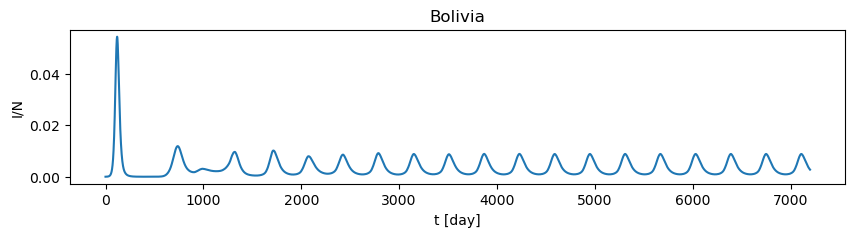

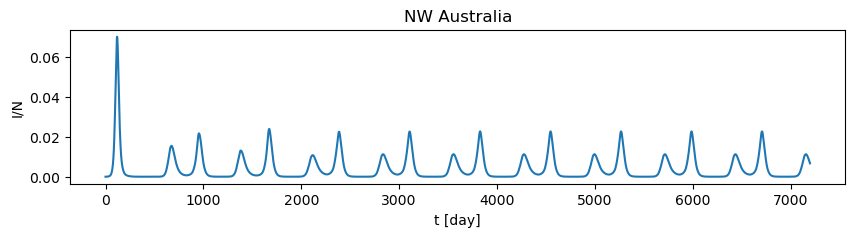

In [10]:
# check what the spun-up infections look like
import matplotlib.pyplot as plt
ds.ii.sel(longitude = -60, latitude=-18, method='nearest').plot(figsize=(10,2))
plt.title('Bolivia')
ds.ii.sel(longitude = 128, latitude=-18, method='nearest').plot(figsize=(10,2))
plt.title('NW Australia')

In [ ]:
# save file
# 3m 36s
encoding = {
    'ss': {'dtype': 'float32', 'zlib': True, 'complevel': 1},
    'ii': {'dtype': 'float32', 'zlib': True, 'complevel': 1},
    }
print(f'saving data to netcdf ...')

ofile = './SIRSmodel_output/climatology_HKU1_MERRA2_weekly_SIRS_output.nc'

ds.to_netcdf(ofile, encoding=encoding)
print('[saved]:', ofile)


# run the 1981-2017 data

In [9]:
# get specific humidity data from file (MERRA2 daily mean)
q = get_q(case='merra2')

In [10]:
q

<xarray.DataArray 'QV2M' (time: 13508, latitude: 361, longitude: 576)>
[2808799488 values with dtype=float32]
Coordinates:
  * time       (time) datetime64[ns] 1981-01-04T12:00:00 ... 2017-12-28T12:00:00
  * longitude  (longitude) float64 -180.0 -179.4 -178.8 ... 178.1 178.8 179.4
  * latitude   (latitude) float64 -90.0 -89.5 -89.0 -88.5 ... 89.0 89.5 90.0
Attributes:
    standard_name:   2-meter_specific_humidity
    long_name:       2-meter_specific_humidity
    units:           kg kg-1
    fmissing_value:  1000000000000000.0
    vmax:            1000000000000000.0
    vmin:            -1000000000000000.0

In [11]:
# Get R0 from q
# 1m 12s
R0 = q2R0(q, **climdepens[dis])

# save R0
# 7s
R0.to_netcdf('./SIRSmodel_input/HKU1_MERRA2_weekly_R0.nc')

In [12]:
# load output from end of climatology run
clim = xr.open_dataset('./SIRSmodel_output/climatology_HKU1_MERRA2_weekly_SIRS_output.nc')

# get last timestamp for initial conditions
ii0 = clim.ii.isel(t=-1)
ss0 = clim.ss.isel(t=-1)

In [13]:
# run the model with those initial conditions
# 9m 21s

ds = run_climSIRS(T = R0.time.size - 1, 
                  dt=dt, L=L, D=D, R0=R0, dis=dis,
                 ii0=ii0, ss0=ss0)

[    0     1     2 ... 13504 13505 13506]
time analyzed: 365x1; 365x2; 365x3; 365x4; 365x5; 365x6; 365x7; 365x8; 365x9; 365x10; 365x11; 365x12; 365x13; 365x14; 365x15; 365x16; 365x17; 365x18; 365x19; 365x20; 365x21; 365x22; 365x23; 365x24; 365x25; 365x26; 365x27; 365x28; 365x29; 365x30; 365x31; 365x32; 365x33; 365x34; 365x35; 365x36; 365x37; 


In [14]:
ds

<xarray.Dataset>
Dimensions:    (longitude: 576, latitude: 361, t: 13507)
Coordinates:
  * longitude  (longitude) float64 -180.0 -179.4 -178.8 ... 178.1 178.8 179.4
  * latitude   (latitude) float64 -90.0 -89.5 -89.0 -88.5 ... 89.0 89.5 90.0
  * t          (t) int64 0 1 2 3 4 5 6 ... 13501 13502 13503 13504 13505 13506
Data variables:
    ss         (t, latitude, longitude) float32 0.4091 0.4091 ... 0.5733 0.5733
    ii         (t, latitude, longitude) float32 0.005822 0.005822 ... 0.01399
    year       (t) float64 0.0 0.00274 0.005479 0.008219 ... 37.0 37.0 37.0

In [15]:
# save file
# 7m 3s
encoding = {
    'ss': {'dtype': 'float32', 'zlib': True, 'complevel': 1},
    'ii': {'dtype': 'float32', 'zlib': True, 'complevel': 1},
    }
print(f'saving data to netcdf ...')

ofile = './SIRSmodel_output/HKU1_MERRA2_weekly_SIRS_output.nc'

ds.to_netcdf(ofile, encoding=encoding)
print('[saved]:', ofile)

saving data to netcdf ...
[saved]: ./SIRSmodel_output/HKU1_MERRA2_weekly_SIRS_output.nc


Text(0.5, 1.0, 'NW Australia')

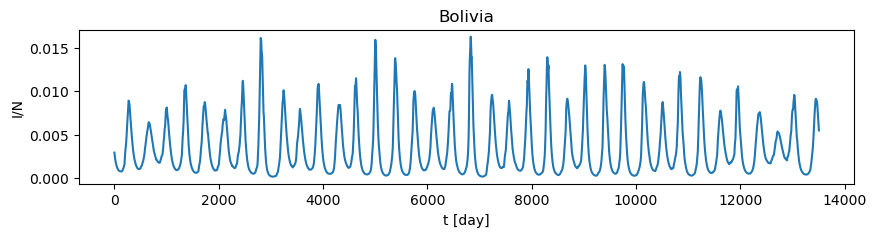

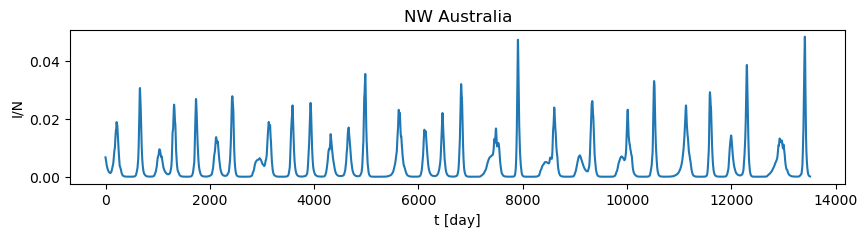

In [16]:
# check what the spun-up infections look like

ds = xr.open_dataset('./SIRSmodel_output/HKU1_MERRA2_weekly_SIRS_output.nc')

import matplotlib.pyplot as plt
ds.ii.sel(longitude = -63, latitude=-19, method='nearest').plot(figsize=(10,2))
plt.title('Bolivia')
ds.ii.sel(longitude = 128, latitude=-18, method='nearest').plot(figsize=(10,2))
plt.title('NW Australia')